# Packing and influence on cell motility

Some time ago Hadrien Mary [@Hadim_](https://twitter.com/Hadim_) asked me if tyssue could reproduce this work:

<blockquote class="twitter-tweet" data-lang="fr"><p lang="en" dir="ltr">The subtle mechanics of densely packed cells may help explain why some cancerous tumors stay put while others spread <a href="https://t.co/G6lbhLhQxQ">https://t.co/G6lbhLhQxQ</a> <a href="https://t.co/AK9SzzUazU">pic.twitter.com/AK9SzzUazU</a></p>&mdash; Quanta Magazine (@QuantaMagazine) <a href="https://twitter.com/QuantaMagazine/status/907371443025039361?ref_src=twsrc%5Etfw">11 septembre 2017</a></blockquote>
<script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script>


![Cellular traffic jam](./data/gif/cellular_traffic_jam.gif)

Illustration is from [Lucy Reading](https://www.lucyreading.co.uk/) [@LucyIkkanda](https://twitter.com/LucyIkkanda)

The relevant model is described in [Mapeng Bi et al.](https://arxiv.org/abs/1409.0593v4) ([nature physics version ($$)](https://www.nature.com/articles/nphys3471))

The master equation is the following:

$$\epsilon = \sum_\alpha \left[ (a_\alpha - 1)^2 + \frac{(p_\alpha - p_0)^2}{r}\right]$$

With a unit prefered area and $p_\alpha$ the cell perimeter.

### Imports

In [1]:
import numpy as np
import pandas as pd

from tyssue import config, Sheet, PlanarGeometry
from tyssue.solvers import QSSolver

from tyssue.solvers.viscous import EulerSolver
from tyssue.draw import sheet_view

from tyssue.dynamics.factory import model_factory
from tyssue.dynamics import effectors, units

from tyssue.utils import to_nd
from tyssue.utils.testing import effector_tester, model_tester
from tyssue.behaviors import EventManager
from tyssue.behaviors.sheet import basic_events

from tyssue.draw import highlight_faces, create_gif

### Create a 2D patch of cells

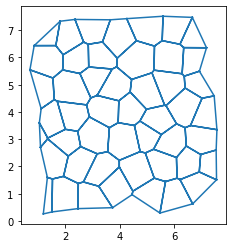

In [2]:
geom = PlanarGeometry

sheet = Sheet.planar_sheet_2d('jam', 15, 15, 1, 1, noise=0.2)
geom.update_all(sheet)

sheet.remove(sheet.cut_out([[0, 8], [0, 8]]), trim_borders=True)
sheet.sanitize()
geom.scale(sheet, sheet.face_df.area.mean()**-0.5, ['x', 'y'])
geom.update_all(sheet)
sheet.reset_index()
sheet.reset_topo()
fig, ax = sheet_view(sheet, mode="quick")

### Define the relevant mechanical components 

In [3]:
   
# Adding some gigling
class BrownianMotion(effectors.AbstractEffector):
    
    label = 'Brownian Motion'
    element = 'vert'
    specs = {"settings": {"temperature": 1e-3}}
    
    def energy(eptm):
        T = eptm.settings['temperature']
        return np.ones(eptm.Nv) * T / eptm.Nv
    
    def gradient(eptm):
        T = eptm.settings['temperature']
        scale = T/eptm.edge_df.length.mean()
        
        grad = pd.DataFrame(
            data=np.random.normal(0, scale=scale, size=(eptm.Nv, eptm.dim)),
            index=eptm.vert_df.index,
            columns=['g'+c for c in eptm.coords]
        )
        return grad, None
    
    



### Quasistatic gradient descent

With only the conservative potential terms

In [4]:

model = model_factory(
    [effectors.PerimeterElasticity,
     effectors.FaceAreaElasticity])


model_specs = {
    'face': {
        'area_elasticity': 1.,
        'prefered_area': 1.,
        'perimeter_elasticity': 0.1, # 1/2r in the master equation
        'prefered_perimeter': 3.81,
        },
    'edge': {
        'ux': 0,
        'uy': 0,
        'is_active': 1,
        'line_tension': 0.0
    },
    'settings': {'temperature': 1e-2}
}
    
sheet.update_specs(model_specs, reset=True)

res = QSSolver().find_energy_min(sheet, PlanarGeometry, model)

print(res.message)

Reseting column ux of the edge dataset with new specs
Reseting column uy of the edge dataset with new specs


CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH


Backup so we can play with parameters

In [5]:
bck = sheet.copy()

## Pulling on a face


In [6]:
    
def tract(eptm, face, pull_axis, value, pull_column='line_tension', face_id=None):
    """Modeling face traction as shrinking apical junctions on the neighouring cells,
    
    As if pseudopods where pulling between the cells
    
    
    """
    
    
    pull_axis = np.asarray(pull_axis)
    edges = eptm.edge_df.query(f'face == {face}')
    verts = edges['srce'].values
    r_ai = edges[["r"+c for c in eptm.coords]].values
    proj = (r_ai * pull_axis[None, :]).sum(axis=1)
    
    pulling_vert = verts[np.argmax(proj)]
    
    v_edges = eptm.edge_df.query(
        f'(srce == {pulling_vert}) & (face != {face})'
    )
    pulling_edges = v_edges[~v_edges['trgt'].isin(verts)].index
    eptm.edge_df[pull_column] = 0

    if pulling_edges.size:
        eptm.edge_df.loc[pulling_edges, pull_column] = value
        
        
default_traction_spec = {
    "face": -1,
    "face_id": -1,
    "pull_axis": [0.1, 0.9],
    "value": 4,
    "pull_column": "line_tension"
}


from tyssue.utils.decorators import face_lookup

@face_lookup
def traction(sheet, manager, **kwargs):
    
    traction_spec = default_traction_spec
    traction_spec.update(**kwargs)
    pulling = tract(sheet, **traction_spec)
    
    manager.append(traction, **traction_spec)


In [7]:
pulled = 2

#### Simple visualisation

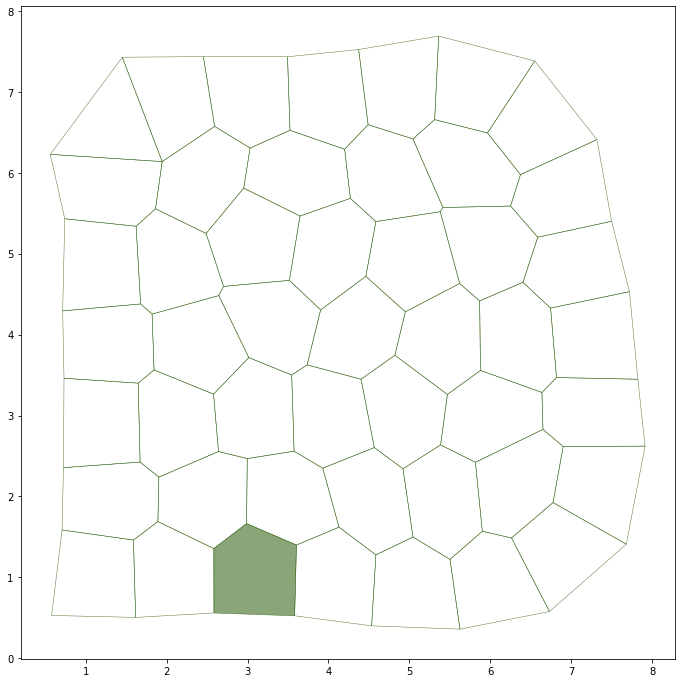

In [8]:
highlight_faces(sheet.face_df, [pulled,], reset_visible=True)
fig, ax = sheet_view(
    sheet, 
    mode="2D", 
    face={"visible": True},
    edge={"head_width": 0.0}, 
    vert={"visible": False})
fig.set_size_inches(12, 12)

####  Model with all the components

In [9]:
model = model_factory(
    [effectors.PerimeterElasticity,
     BrownianMotion,
     effectors.LineTension,
     effectors.FaceAreaElasticity])

### Setup the event manager and the solver

In [9]:
sheet = bck.copy()


# setting up values for the whole epithelium
model_specs = {
    'face': {
        'area_elasticity': 1.,
        'prefered_area': 1.,
        'perimeter_elasticity': 0.05, # 1/2r in the master equation
        'prefered_perimeter': 3.81,
        "id": sheet.face_df.index
        },
    'vert': {
        "viscosity": 1.0
        },
    'edge': {'ux': 0, 'uy': 0},
    'settings': {
        'temperature': 2e-1,
        "p_4": 10.0,
        "p_5p": 1.0,
        "threshold_length": 2e-2
    }
}

sheet.update_specs(model_specs, reset=True)

# This allows to auomaticaly solve topology changes

manager = EventManager("face", )
manager.append(basic_events.reconnect)
manager.append(traction, face_id=pulled)

# Implicit Euler solver

solver = EulerSolver(
    sheet,
    geom,
    model,
    manager=manager,
    bounds=(
        -sheet.edge_df.length.median()/10,
        sheet.edge_df.length.median()/10
    )
)
manager.update()


sheet.face_df['prefered_perimeter'] = 3.8

Reseting column area_elasticity of the face dataset with new specs
Reseting column prefered_area of the face dataset with new specs
Reseting column perimeter_elasticity of the face dataset with new specs
Reseting column prefered_perimeter of the face dataset with new specs
Reseting column id of the face dataset with new specs
Reseting column ux of the edge dataset with new specs
Reseting column uy of the edge dataset with new specs


### Run the solver

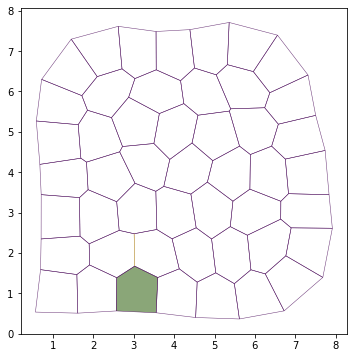

In [10]:

    
solver.solve(tf=120.0, dt=0.1)

highlight_faces(sheet.face_df, [pulled,], reset_visible=True)

fig, ax = sheet_view(
    sheet,
    mode="2D",
    face={"visible": True},
    edge={"head_width": 0.0, "color": sheet.edge_df["line_tension"]},
    vert={"visible": False}
)
fig.set_size_inches(6, 6)


### Define a simple drawing function

In [11]:
def view(sheet):
    highlight_faces(sheet.face_df, [pulled], reset_visible=True)
    geom.update_all(sheet)
    if sheet.edge_df['line_tension'].max():
        ecolor = sheet.edge_df['line_tension']
    else:
        ecolor = "#aaaaaa"
        
    fig, ax = sheet_view(
        sheet,
        mode="2D",
        face={"visible": True},
        edge={"head_width": 0.0, "color": ecolor, "width": 2},
        vert={"visible": False}
    )
    fig.set_size_inches(8, 8)
    ax.set_xticks([])
    ax.set_yticks([])
    
    return fig, ax

### Create a gif of the resulting simulation


In [12]:
create_gif(solver.history, "demo.gif", draw_func=view, num_frames=120)

In [13]:
solver.history.time_stamps

array([0.000e+00, 1.000e-01, 2.000e-01, ..., 1.198e+02, 1.199e+02,
       1.200e+02])

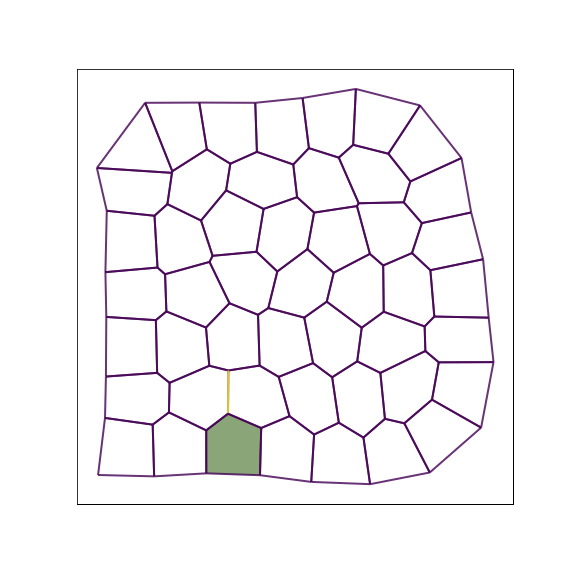

In [15]:
from IPython.display import Image
Image("demo.gif")

![](test_rigid.gif)